In [1]:
import glob, pickle
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
#Enlargen
sns.set_context('poster')

plt.style.use('fivethirtyeight')

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [37]:
# The date of the prices is only found in the .csv filename
def extract_date(filename):
    return datetime.date(int(filename[20:24]), int(filename[18:20]), int(filename[16:18]))

def merge_csvs(filenames):
    files = []
    for filename in filenames:
        df = pd.read_csv(filename)
        df['Date'] = extract_date(filename)
        files.append(df)
    return pd.concat(files)

def output_figure(filename):
    """
    Save the most recently generated chart as a png with the filename passed as an argument
    """
    plt.tight_layout()
    plt.savefig('./charts/' + filename + '.png', dpi=300)

In [3]:
csvfiles = glob.glob('./raw/*.csv')
df = merge_csvs(csvfiles)

In [4]:
# Cleaning

# Remove odd string in low quality weed prices

df['LowQ'].replace('I feel bad for these guys -->', np.nan, inplace=True)

# Remove occasional $s to convert all prices to float

for col in ['HighQ','MedQ','LowQ']:
    df.ix[:,col] = [float(str(x).replace('$','')) for x in df[col].values]

In [5]:
# Create data for overall median prices from 2013-2015 map

avgstateprices = df.groupby('State').aggregate(np.median)

'''
After looking at the data, a few states with a small number of observations for low quality weed prices have
unreasonably high prices; I'm rounding them down to the highest "reasonable" value here to keep the map scale well-
bounded
'''

outlier_states = ['Montana','New Hampshire','Alaska', 'North Dakota']
avgstateprices.loc[outlier_states,'LowQ'] = avgstateprices.loc['Maine','LowQ']

avgstateprices.to_csv('./outputs/Average_prices.csv')

In [6]:
# Reformat data for animated map with monthly median prices

df['Month'] = [x.month for x in df['Date']]
df['Year'] = [x.year for x in df['Date']]

high_ts = pd.DataFrame(df.groupby(['State','Month','Year']).aggregate(np.median)['HighQ'])
high_ts.reset_index(inplace=True)

In [7]:
# Restructure dataset so rows are states and columns are unique month + year combinations

high_ts['MonthYear'] = ['{:02d}'.format(x) + str(y) for x, y in zip(high_ts['Month'].values, high_ts['Year'].values)]

del high_ts['Month']
del high_ts['Year']

high_ts = high_ts.pivot(columns='MonthYear', index='State')

In [8]:
# Remove unnecessary MultiIndex

high_ts.columns.names=[None, None]
high_ts.columns = high_ts.columns.droplevel()
high_ts.reset_index(inplace=True)

In [9]:
high_ts.to_csv('./outputs/High_quality_prices_over_time.csv', index=False)

In [10]:
# State Cluster Analysis

# Restructure DF
cluster_df = high_ts.set_index('State').transpose()
cluster_df.index = pd.to_datetime(cluster_df.index, format='%m%Y')
cluster_df.sort_index(inplace=True)

In [11]:
smoothed_cluster_df = pd.ewma(cluster_df,span=30)

percent_chg_df = smoothed_cluster_df.pct_change()

# Remove first row since it's NaN for % change
percent_chg_df.drop(percent_chg_df.index[0:2], inplace=True)

In [12]:
# best_score = {'silhouette': 0, 'n_clusters': 0, 'assignment': None}

# X = percent_chg_df.transpose().values
    
# for param in (np.arange(10)+3):
#     for i in range(50):
#         clf = KMeans(n_clusters=param)
#         clf.fit(X)
#         clusters = pd.Series(clf.predict(X), index=percent_chg_df.columns)
#         if silhouette_score(X,clusters.values) > best_score['silhouette']:
#             best_score['silhouette'] = silhouette_score(X,clusters.values)
#             best_score['n_clusters'] = param
#             best_score['assignment'] = clusters

In [13]:
# with open('cluster.pkl', 'wb') as file:
#     pickle.dump(best_score,file)

In [14]:
with open('cluster.pkl', 'rb') as file:
    best_score = pickle.load(file)

clusters = best_score['assignment']
cluster_states = dict()
for i in (1 + np.arange(best_score['n_clusters'])):
    cluster_states[i] = list(clusters[clusters == i-1].index)

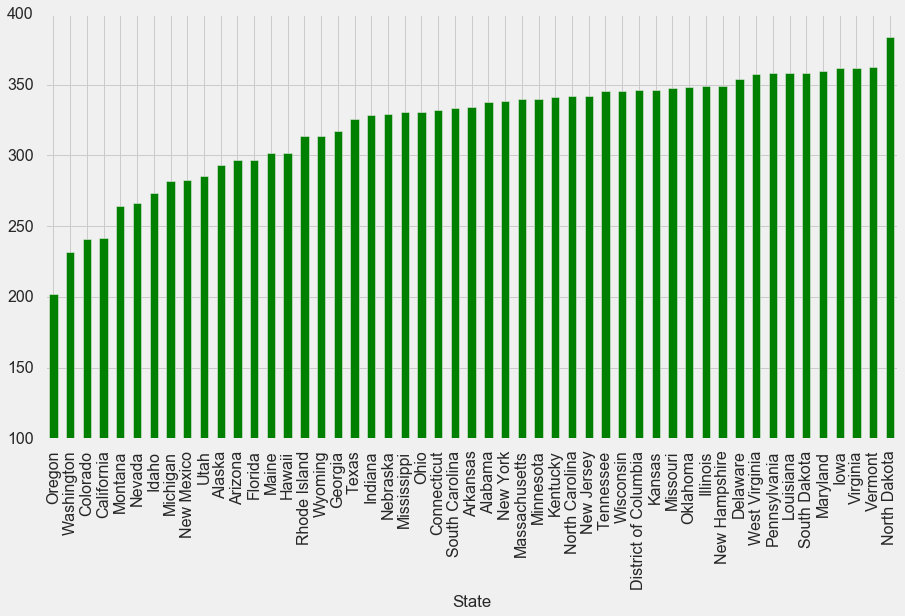

In [38]:
#States ranked by prices at end
with plt.style.context('fivethirtyeight'):
    cluster_df.ix['2015-07-01',:].sort_values().plot(kind='bar', color='green', ylim=(100,400))
    output_figure('states_final_prices_ranked')

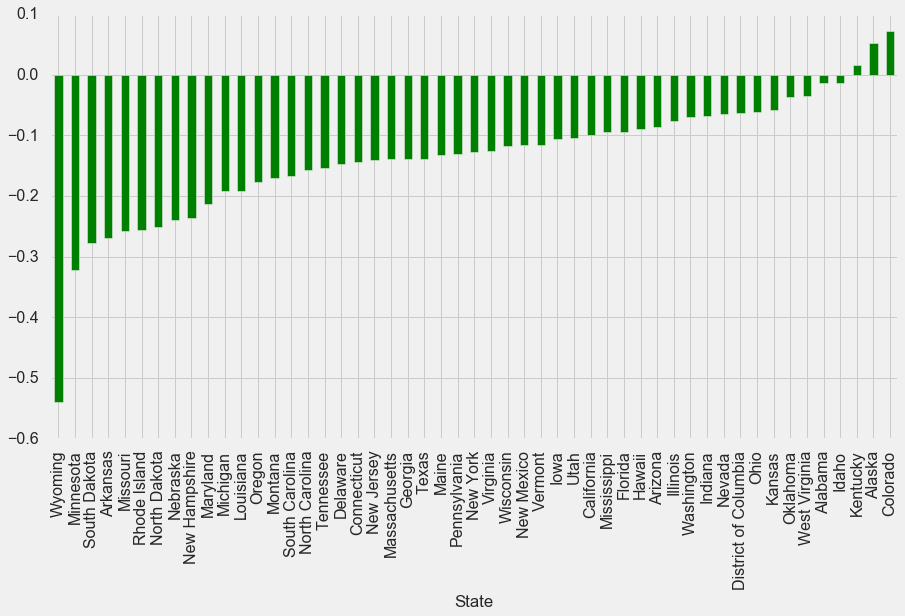

In [39]:
# States ranked by average monthly price change

with plt.style.context('fivethirtyeight'):
    (percent_chg_df.median()*100).sort_values().plot(kind='bar', color='green')
    output_figure('states_monthly_price_change_ranked')

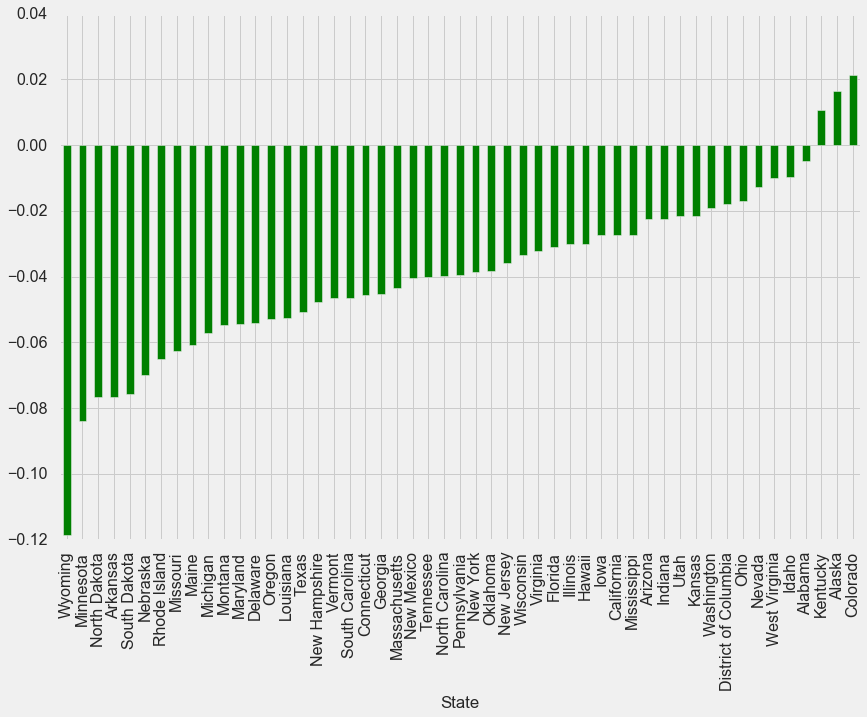

In [17]:
#Overall Percent Change

overall_pct_change = (cluster_df.ix['2015-07-01',:] - cluster_df.ix['2013-12-01',:])/cluster_df.ix['2013-12-01',:]
overall_pct_change.sort_values().plot(kind='bar', color='green')

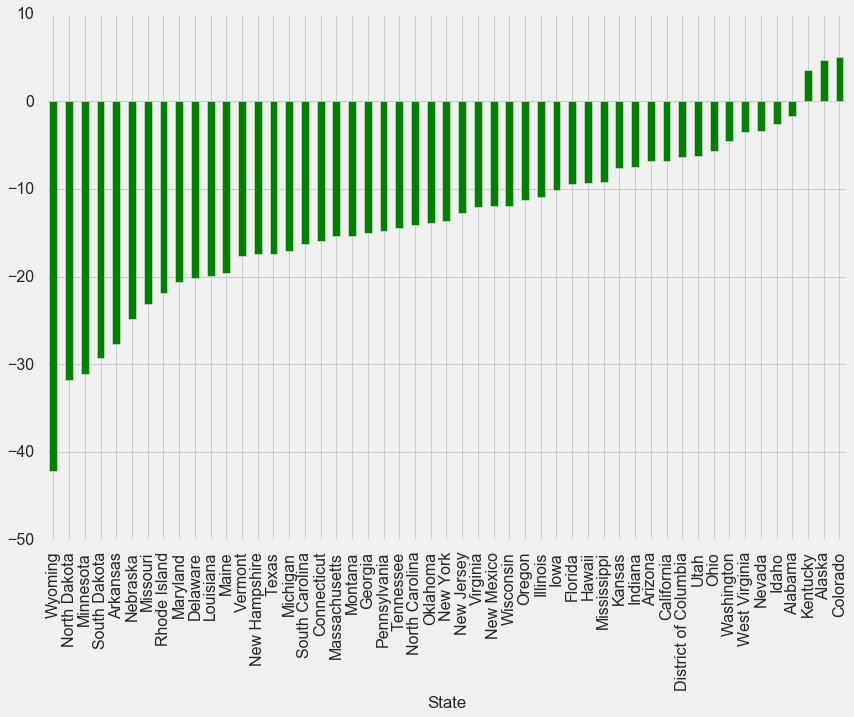

In [18]:
#Dollar change

dollar_change = (cluster_df.ix['2015-07-01',:] - cluster_df.ix['2013-12-01',:])
dollar_change.sort_values().plot(kind='bar', color='green')

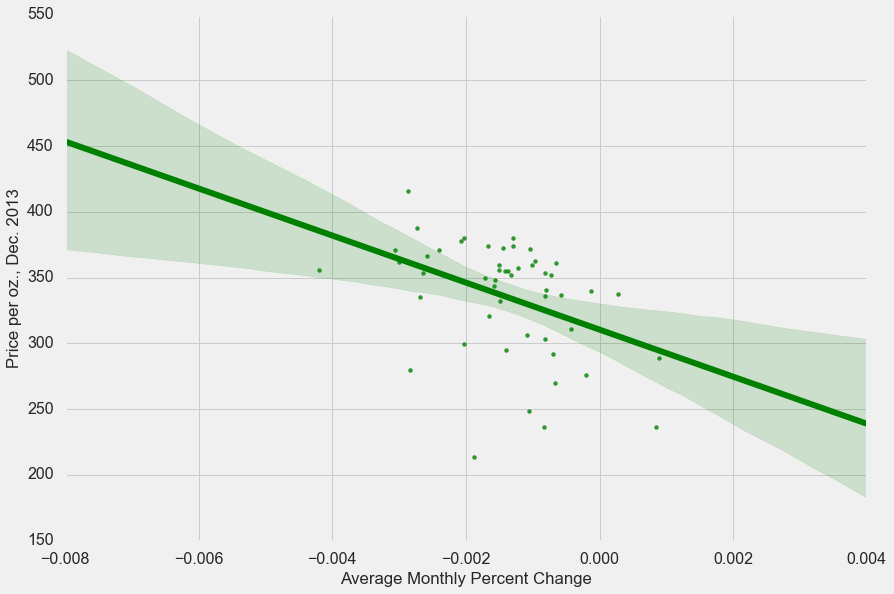

In [19]:
# Hey, a clear negative relationship = price convergence

scatter_df = pd.concat([pd.Series(percent_chg_df.mean(),name='Average Monthly Percent Change'),pd.Series(cluster_df.ix['2013-12-01',:],name='Price per oz., Dec. 2013')],axis=1)

sns.regplot(x=scatter_df.columns[0],y=scatter_df.columns[1],data=scatter_df, color='green')

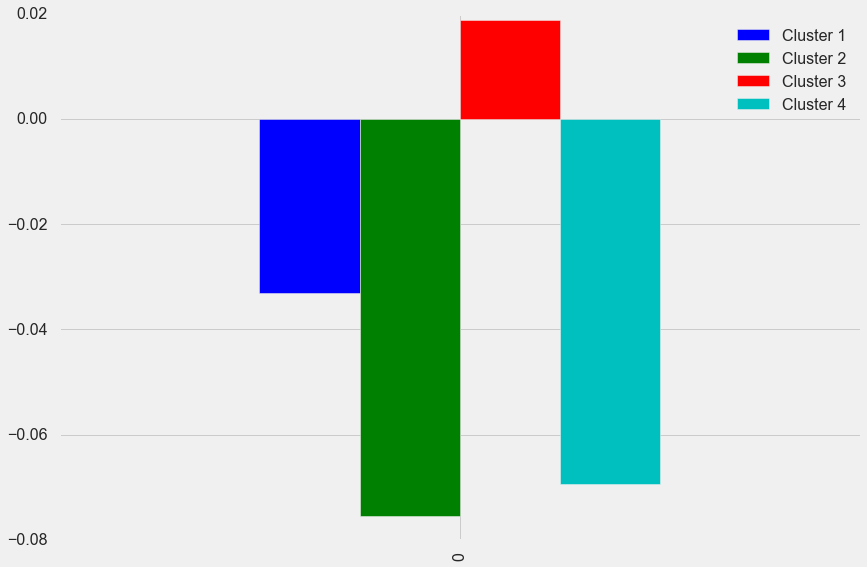

In [20]:
# Overall % change by clusters

series = []
for key in cluster_states.keys():
    series.append(pd.Series(overall_pct_change[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
overall_pct_clusters = pd.concat(series, axis=1)

overall_pct_clusters.plot(kind='bar')

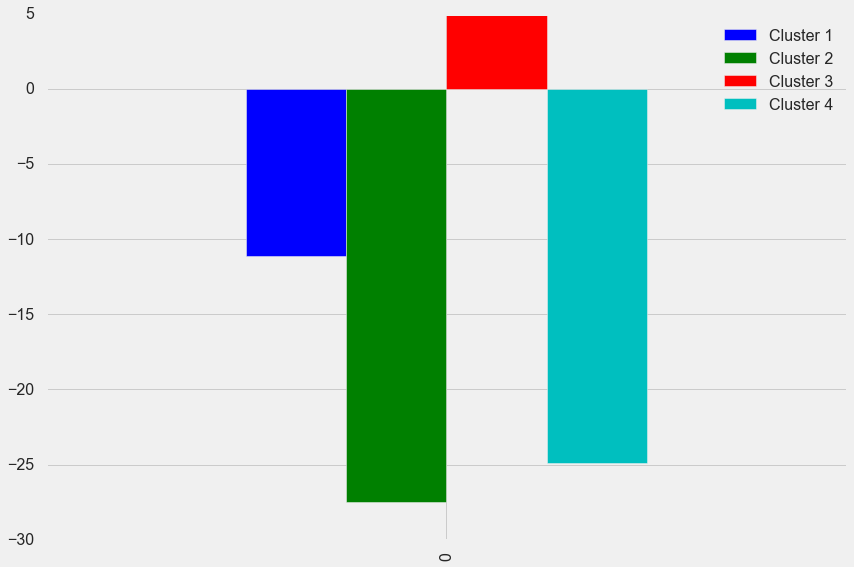

In [21]:
# Overall $ change by clusters

series = []
for key in cluster_states.keys():
    series.append(pd.Series(dollar_change[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
dollar_change_clusters = pd.concat(series, axis=1)

dollar_change_clusters.plot(kind='bar')

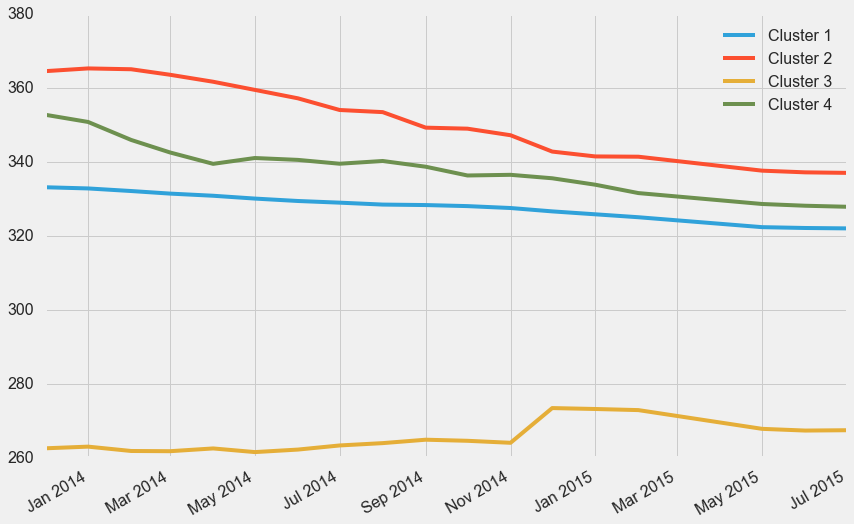

In [22]:
# Average time trends by cluster
series = []
for key in cluster_states.keys():
    series.append(pd.Series(cluster_df[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
cluster_ts = pd.concat(series, axis=1)

cluster_ts.plot()

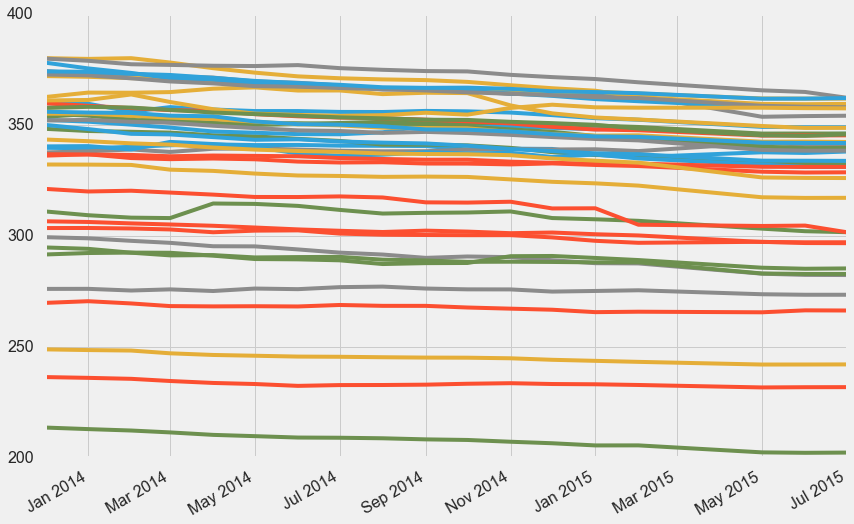

In [23]:
cluster_df[cluster_states[1]].plot(legend=False)

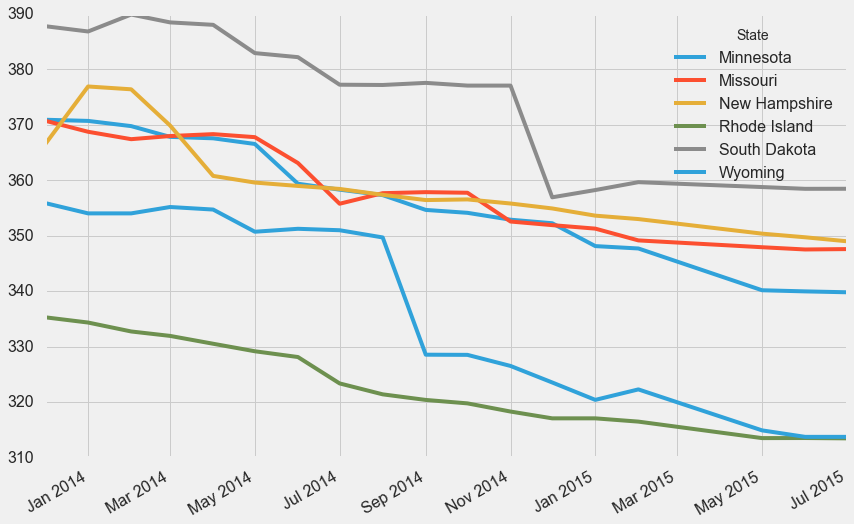

In [24]:
cluster_df[cluster_states[2]].plot()

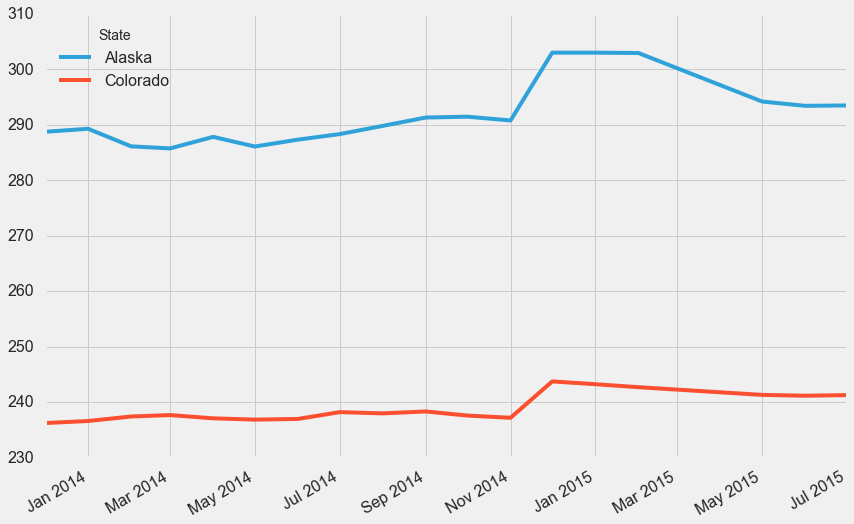

In [25]:
cluster_df[cluster_states[3]].plot()

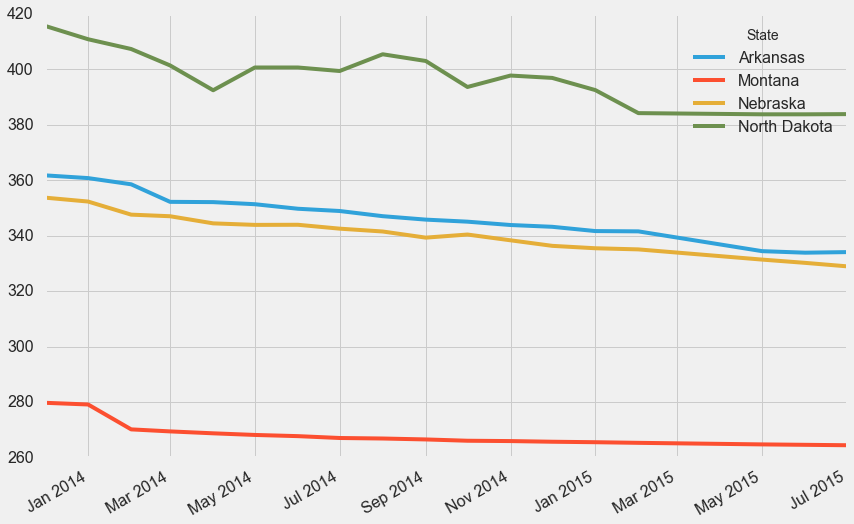

In [26]:
cluster_df[cluster_states[4]].plot()